# Importing Libraries

In [1]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from keras.optimizers import Adam
import matplotlib.pyplot as plt

2023-08-23 01:13:44.238562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 01:13:47.498081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-23 01:13:47.498152: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-23 01:13:56.669515: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Car Rental Environment

In [2]:
class CarRentalEnvironment:
    def __init__(self, max_cars=20, max_move=5, move_cost=2,
    rent_reward=10, discount_factor=0.9):
        self.max_cars = max_cars
        self.max_move = max_move
        self.move_cost = move_cost
        self.rent_reward = rent_reward
        self.discount_factor = discount_factor

        self.request_means = {
            1: [5, 3],  # Sunday
            2: [4, 3],  # Monday
            3: [3, 3],  # Tuesday
            4: [2, 1],  # Wednesday
            5: [1, 2],  # Thursday
            6: [4, 5],  # Friday
            7: [3, 5]   # Saturday
        }

        self.return_means = {
            1: [5, 4],  # Sunday
            2: [5, 3],  # Monday
            3: [4, 3],  # Tuesday
            4: [3, 3],  # Wednesday
            5: [2, 1],  # Thursday
            6: [1, 2],  # Friday
            7: [5, 4]   # Saturday
        }

        # There are 441 * 7 = 3087 states
        # We represent each state with a tuple of three elements: (cars_at_loc1, cars_at_loc2, day_of_the_week)
        self.state_space = [(i, j, k) for i in range(max_cars + 1) for j in range(max_cars + 1) for k in range(1,8)]
        # There are 11 actions: (-6, 6) exclusive
        self.action_space = range(-max_move, max_move+1)
        self.day_of_the_week = 1
        self.state = (0, 0, self.day_of_the_week)


    def step(self, action):
        assert action in self.action_space, "Invalid action!"

        # Get request and return rates for the current day of the week
        request_mean = self.request_means[self.day_of_the_week]
        return_mean = self.return_means[self.day_of_the_week]

        # Simulate car rental requests and returns based on the means for the day of the week
        rental_requests = [np.random.poisson(request_mean[i]) for i in range(2)]
        rental_returns = [np.random.poisson(return_mean[i]) for i in range(2)]

        if action < 0:
            cars_at_loc1 = min(max(self.state[0] + min(abs(action), self.state[1]), 0), self.max_cars)
            cars_at_loc2 = min(max(self.state[1] - min(abs(action), self.state[1]), 0), self.max_cars)
            move1 = abs(self.state[0] - cars_at_loc1)
            move2 = abs(self.state[1] - cars_at_loc2)
            move = max(move1,move2)
        if action >= 0:
            cars_at_loc1 = min(max(self.state[0] - min(abs(action), self.state[0]), 0), self.max_cars)
            cars_at_loc2 = min(max(self.state[1] + min(abs(action), self.state[0]), 0), self.max_cars)
            move1 = abs(self.state[0] - cars_at_loc1)
            move2 = abs(self.state[1] - cars_at_loc2)
            move = max(move1,move2)

        # Calculate reward for renting cars
        rent_reward = self.rent_reward * min(self.state[0], rental_requests[0])
        rent_reward += self.rent_reward * min(self.state[1], rental_requests[1])

        # Update the state based on rentals and returns
        cars_at_loc1 -= min(cars_at_loc1, rental_requests[0])
        cars_at_loc2 -= min(cars_at_loc2, rental_requests[1])
        cars_at_loc1 += rental_returns[0]
        cars_at_loc2 += rental_returns[1]

        # Ensure the number of cars at each location does not exceed the maximum limit
        cars_at_loc1 = min(cars_at_loc1, self.max_cars)
        cars_at_loc2 = min(cars_at_loc2, self.max_cars)

        # Calculate total reward as the sum of rent_reward and moving cost (if any)
        total_reward = rent_reward - move * self.move_cost

        self.day_of_the_week += 1
        if self.day_of_the_week > 7:
            self.day_of_the_week = 1
        self.state = (cars_at_loc1, cars_at_loc2, self.day_of_the_week)

        # Return the next state, reward, and done flag
        return self.state, total_reward
    def reset(self):
        # Reset the environment to the initial state
        self.state = (0, 0, 1)
        return self.state


# NN with two hidden layers

In [3]:
def build_model(input_shape, output_size, lr=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(output_size)
    ])
    model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=lr), metrics=['acc'])
    return model

# Function to test the agent

In [4]:
def run_episodes_continuous(env, online_network, target_network, num_steps=100, num_episodes=1):
    '''
    Run some episodes to test the policy in the continuous environment
    '''
    tot_rew = []

    for ep in range(num_episodes):
        state = env.reset()
        game_rew = 0

        for t in range(num_steps):
            # Select a greedy action using the online network
            q_values = online_network.predict(np.reshape(state, (1, -1)), verbose=0)
            action = np.argmax(q_values[0])

            next_state, rew = env.step(env.action_space[action])

            # Update the next state to its index representation
            game_rew += rew

            # Check if the episode is done
            if t == num_steps - 1:
                done = True
            else:
                done = False

            # Check if we are at the end of the episode
            if done:
                tot_rew.append(game_rew)
                break

            state = next_state

    return np.mean(tot_rew)

# Function to balance between exploration vs exploitation

In [5]:
def exploration_rate(min_rate, max_rate, decay_rate, episode):
    return min_rate + (max_rate - min_rate) * np.exp(-decay_rate * episode)

# DQN Training

In [6]:
def dqn_train(env, num_episodes=2000, max_steps_per_episode=7, batch_size=64, gamma=0.95, epsilon_max=1.0, epsilon_min=0.1, epsilon_decay=0.0005):
    replay_buffer = deque(maxlen=2000)
    buffer_batch_start = 1000
    input_shape = (len(env.state_space[0]),)
    output_size = len(env.action_space)

    # Build the online and target networks
    online_network = build_model(input_shape, output_size)
    target_network = build_model(input_shape, output_size)
    target_network.set_weights(online_network.get_weights())

    test_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        state = np.reshape(state, (1, -1))
        total_reward = 0

        epsilon = exploration_rate(epsilon_min, epsilon_max, epsilon_decay, episode)

        for step in range(max_steps_per_episode):
            if np.random.rand() <= epsilon:
                action = np.random.choice(len(env.action_space))
            else:
                q_values = online_network.predict(state, verbose=0)
                action = np.argmax(q_values[0])

            next_state, reward = env.step(env.action_space[action])
            next_state = np.reshape(next_state, (1, -1))

            replay_buffer.append((state, action, reward, next_state))
            state = next_state
            total_reward += reward

            while len(replay_buffer) < buffer_batch_start:
                state = env.reset()
                state = np.reshape(state, (1, -1))

                for _ in range(max_steps_per_episode):
                    action = np.random.choice(len(env.action_space))
                    next_state, reward = env.step(env.action_space[action])
                    next_state = np.reshape(next_state, (1, -1))
                    replay_buffer.append((state, action, reward, next_state))
                    state = next_state

            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                states, actions, rewards, next_states = zip(*batch)

                states = np.concatenate(states)
                next_states = np.concatenate(next_states)

                q_values = online_network.predict(states, verbose=0)
                q_values_next = target_network.predict(next_states, verbose=0)

                target_q_values = q_values.copy()

                for i in range(batch_size):
                    target = rewards[i] + gamma * np.max(q_values_next[i])
                    target_q_values[i, actions[i]] = target
                
                if episode == 0:
                    test_reward = run_episodes_continuous(env, online_network, target_network)
                    test_rewards.append(test_reward)
                    print("Test Reward after {} episodes: {:.2f}".format(episode + 1, test_reward))

                online_network.fit(states, target_q_values, epochs=1, verbose=0)

#         if (episode + 1) % 100 == 0:
#             current_lr = online_network.optimizer.lr.numpy()
#             new_lr = current_lr * 0.5  # Reduce learning rate by half
#             online_network.optimizer.lr.assign(new_lr)
#             print("Reduced learning rate to:", new_lr)
        if episode % 100 == 0:
            target_network.set_weights(online_network.get_weights())  # Update target network

        if (episode + 1) % 50 == 0:
            test_reward = run_episodes_continuous(env, online_network, target_network)
            test_rewards.append(test_reward)
            print("Test Reward after {} episodes: {:.2f}".format(episode + 1, test_reward))
            
    return online_network, test_rewards


In [7]:
if __name__ == '__main__':
    env = CarRentalEnvironment()
    trained_network, test_rewards = dqn_train(env)
    print("Final Test Rewards:", test_rewards)

2023-08-23 01:14:14.900135: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-23 01:14:14.900239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Magnus): /proc/driver/nvidia/version does not exist
2023-08-23 01:14:14.930507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Test Reward after 1 episodes: 5742.00
Test Reward after 1 episodes: 5674.00
Test Reward after 1 episodes: 5848.00
Test Reward after 1 episodes: 5788.00
Test Reward after 1 episodes: 6200.00
Test Reward after 1 episodes: 5880.00
Test Reward after 1 episodes: 5736.00
Test Reward after 50 episodes: 4760.00
Test Reward after 100 episodes: 4814.00
Test Reward after 150 episodes: 4678.00
Test Reward after 200 episodes: 5038.00
Test Reward after 250 episodes: 5262.00
Test Reward after 300 episodes: 5866.00
Test Reward after 350 episodes: 5908.00
Test Reward after 400 episodes: 5982.00
Test Reward after 450 episodes: 5738.00
Test Reward after 500 episodes: 5506.00
Test Reward after 550 episodes: 5820.00
Test Reward after 600 episodes: 5404.00
Test Reward after 650 episodes: 5316.00
Test Reward after 700 episodes: 5842.00
Test Reward after 750 episodes: 5838.00
Test Reward after 800 episodes: 5800.00
Test Reward after 850 episodes: 5978.00
Test Reward after 900 episodes: 6010.00
Test Reward aft

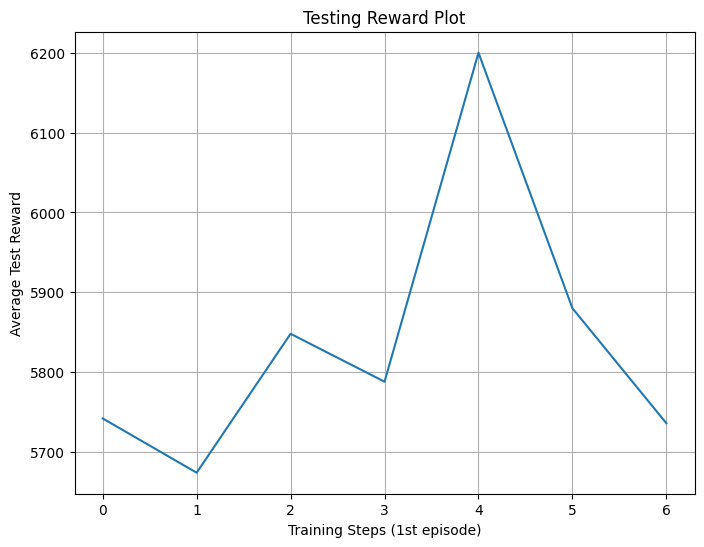

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(range(0, 7, 1), test_rewards[0:7])
plt.xlabel('Training Steps (1st episode)')
plt.ylabel('Average Test Reward')
plt.title('Testing Reward Plot')
plt.grid(True)
plt.savefig('testing_reward_plot.png')  # Save the plot as 'testing_reward_plot.png' in the current directory
plt.show()

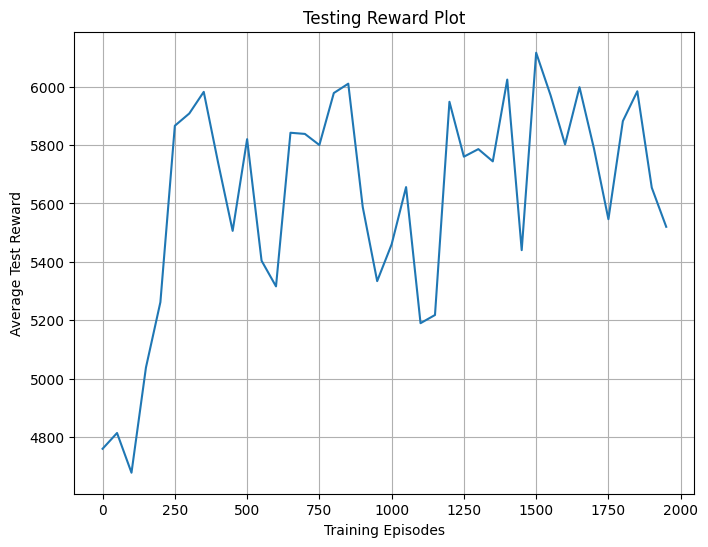

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(range(0, 2000, 50), test_rewards[7:])
plt.xlabel('Training Episodes')
plt.ylabel('Average Test Reward')
plt.title('Testing Reward Plot')
plt.grid(True)
plt.savefig('testing_reward_plot.png')  # Save the plot as 'testing_reward_plot.png' in the current directory
plt.show()